<h1>Lab : simplified JPEG encoder/decoder</h1>

**Read the guidance**

**Read the topic (.pdf file) first**

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Functions to be implemented:**
  - rlencode (in Section 1)
  - count_symbols (in Section 1)
  - and also the 'main' functions (in Section 3)

**Some useful functions:** 
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

**You can directly go to Section 3 and code there**

**Import the libs**

In [60]:
import numpy as np  
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: optional (since there will be a quite easy 'manual' way for doing that)
*   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.** 





In [69]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output
    

def rlencode(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered, 
    the next value is `escape` followed by the number of `symbol`.
    '''
    out = []
    symbols = 0
    for i in range(len(data)):
        if data[i] == symbol:
            symbols += 1
        else:
            if symbols > 0:
                out.append(escape)
                out.append(symbols)
                out.append(data[i])
                symbols = 0
            else:
                out.append(data[i])
    if symbols > 0:
        out.append(escape)
        out.append(symbols)
    return np.array(out)


def count_symbols(data:list) -> Dict[Any, int]:
    '''
    Compute the frequency of each value in the list
    '''
    freq = {}
    #freq should be a dictionary with data as key and frequency as value
    for i in data:
        if i in freq:
            freq[i] += 1
        else:
            freq[i] = 1
    return freq

    
#testing 
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'

rle = {1,5,6,257,61}

output = {1:1,5:1,5:1,0:61}


{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [70]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))
    
    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]
        
        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [71]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)
    
    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [79]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(data)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)



Test 1
{'a': '000', 'e': '001', 't': '0100', 'h': '0101', 'i': '0110', 's': '0111', 'n': '1000', 'm': '1001', 'x': '10100', 'p': '10101', 'l': '10110', 'o': '10111', 'u': '11000', 'r': '11001', 'f': '1101', ' ': '111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1000111110101011011010001
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


#3. TODO: Codage/Decodage

In [73]:
# ZigZag example

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

rdMatrix = np.round(np.random.rand(8,8)*10)

out = np.zeros(64)
for k in range(64):
    out[k] = rdMatrix[lig[k]-1,col[k]-1] # -1 since indexes start from 0 in Python...

print(rdMatrix)
print(out)


[[ 5.  6.  0.  7.  4.  6.  1.  9.]
 [10.  0.  9.  6.  0.  4.  2.  4.]
 [ 2.  7.  7.  2.  6.  8.  7.  3.]
 [ 3.  9.  8.  5.  3.  6. 10.  7.]
 [ 2.  1.  0. 10.  8.  2.  2.  3.]
 [ 3.  4.  3.  8.  2.  8.  4.  5.]
 [ 4. 10.  0.  3.  6.  1.  4.  1.]
 [ 1.  8.  1.  9.  2.  9.  0.  7.]]
[ 5.  6. 10.  2.  0.  0.  7.  9.  7.  3.  2.  9.  7.  6.  4.  6.  0.  2.
  8.  1.  3.  4.  4.  0.  5.  6.  4.  1.  9.  2.  8.  3. 10.  3. 10.  1.
  8.  0.  8.  8.  6.  7.  4.  3. 10.  2.  2.  3.  1.  9.  6.  8.  2.  7.
  3.  4.  1.  2.  9.  4.  5.  1.  0.  7.]


(256, 256) RGB None 0 255


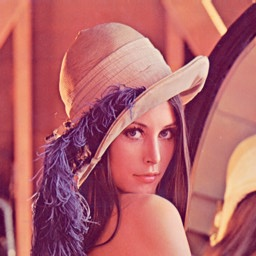

In [ ]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"
imgOriginal = load_from_url(url)
show(imgOriginal)

#TODO: show different channels

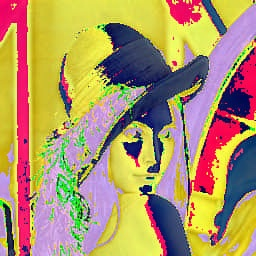

In [242]:

from operator import add
from functools import reduce
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)


# makenxnblocks() is a function that receives an image and returns a list of blocks of size nxn
# the blocks are stored in a list

def makenxnblocks(img, n=8):
    blocks = []
    for i in range(0, img.shape[0], n):
        for j in range(0, img.shape[1], n):
            blocks.append(img[i:i+n, j:j+n])
    return blocks



# centering() receives a list of blocks and returns a list of centered blocks by substracting 128 to each pixel
def centering(blocks):
    centered = []
    for block in blocks:
        centered.append(block - 128)
    return np.array(centered)


#give me the centered function again with but i want to return the same type of array as makexxblocks()

#This is the first block of makexxblocks() 
# array([[142, 142, 143, 143, 144, 143, 141, 138],
#        [142, 142, 142, 143, 143, 141, 138, 137],
#        [141, 141, 141, 140, 140, 139, 137, 134],
#        [139, 139, 139, 139, 139, 138, 135, 134],
#        [136, 136, 136, 136, 137, 137, 136, 134],
#        [135, 135, 135, 135, 136, 135, 135, 134],
#        [135, 134, 134, 134, 134, 134, 134, 133],
#        [135, 135, 134, 134, 134, 134, 133, 132]], dtype=uint8)

#This is the first block of centering(make8x8blocks(img)[0])
# array([[14, 14, 15, 15, 16, 15, 13, 10],
#        [14, 14, 14, 15, 15, 13, 10,  9],
#        [13, 13, 13, 12, 12, 11,  9,  6],
#        [11, 11, 11, 11, 11, 10,  7,  6],
#        [ 8,  8,  8,  8,  9,  9,  8,  6],
#        [ 7,  7,  7,  7,  8,  7,  7,  6],
#        [ 7,  6,  6,  6,  6,  6,  6,  5],
#        [ 7,  7,  6,  6,  6,  6,  5,  4]], dtype=uint8)



#Is necessary to apply this centering on image compression because the DCT is not centered on zero, 
# so we need to center the image to get a better compression


#DCT() receives a list of blocks and returns a list of DCT coefficients of each block
def DCT(blocks):
    dcts= []
    for block in blocks:
        dcts.append(cv2.dct(block))
    return np.array(dcts)


#DCTs = [DCT(block) for block in centering(makenxnblocks(img))]

#quantization takes the floor round of the DCT coefficients divided by the quantization table. This function takes a flag 
#that is "RGB" by default, but can br "chrominance". Depending on the flag the quantization table is chosen between qY or qC respectively
def quantization(DCTs, flag="RGB"):
    quantized = []
    if flag == "RGB":
        for dct in DCTs:
            quantized.append(np.round(dct/qY))
    else:
        for dct in DCTs:
            quantized.append(np.round(dct/qC))
    return np.array(quantized)

#make the return of makenxnblocks floats
def floatify(blocks):
    floatDCTs = []
    for block in blocks:
        floatDCTs.append(block.astype(float))
    return np.array(floatDCTs)


floatDCTs = floatify(centering(makenxnblocks(img)))

afterDCT= DCT(floatDCTs)


firstBlock = quantization(afterDCT)[0]
secondBlock = quantization(afterDCT)[1]
zigzag(firstBlock)



#Make a RungLenght() function to a vector and return the same vector values but everytime if finds a range of zeros if return 
#the number of zeros and the value of the next element preceeded by the element 257
 





vrlc = rlencode(zigzag(firstBlock))


zz = zigzag(firstBlock)




#receive an image and divide the images on blocks of 8x8, apply the DCT, quantization and zigzag and enconde_huffman to all blocks and
# return a list of enconded blocks
def pipeline(img):
    blocks = makenxnblocks(img)
    floatDCTs = floatify(centering(blocks))
    afterDCT= DCT(floatDCTs) #Puede estar mal
    quantized = quantization(afterDCT) #Puede estar mal
    zigzagged = [zigzag(block) for block in quantized]
    rlencoded = [rlencode(elem) for elem in zigzagged] #[1,2,3,257,61]
    encoded = [encode_huffman(block,construct_huffman_table(block)) for block in rlencoded]
    tables = [construct_huffman_table(block) for block in rlencoded]
    return {"encoded":encoded, "tables":tables}

#store the value of the pipeline so i don't call it everytime
transmitted = pipeline(img)





#the function above does not return integer on the matrix, please change it on another function
def decode_pipeline(dict):
    decoded = []
    for i in range(len(dict["encoded"])):
        decoded.append(np.array(decode_huffman(dict["encoded"][i],dict["tables"][i]).tolist()))
    return decoded


#make a function that receives a matrix and return the same matrix with all the values as itengers
def intify(matrix):
    intified = []
    for i in range(len(matrix)):
        intified.append(matrix[i].astype(int).tolist())
    return intified

    
#make rldecode again, with the output as a flattened 1d array
def rldecode(vrlc):
    decoded = np.array([])
    for i in range(len(vrlc)):
        if vrlc[i] == 257:
            decoded=np.append(decoded,np.array([0] * vrlc[i+1]))
        if vrlc[i-1]!=257 and vrlc[i]!=257:
            decoded=np.append(decoded,vrlc[i])
            
    return decoded


decoded_img = intify(decode_pipeline(transmitted))



#apply rldecode to all elements of decoded_img
rldecoded_blocks = [rldecode(elem) for elem in decoded_img]
rldecoded_blocks



#inverse zigzag function
def inverse_zigzag(block):
    n = int(np.sqrt(len(block)))
    matrix = np.zeros((n,n))
    i = 0
    j = 0
    for k in range(len(block)):
        matrix[i][j] = block[k]
        if (i+j)%2 == 0:
            if j<n-1:
                j+=1
            else:
                i+=1
            if i>0:
                i-=1
        else:
            if i<n-1:
                i+=1
            else:
                j+=1
            if j>0:
                j-=1
    return matrix


#inverse quantization function that multiply  element wise for the quatization matrices (depending on the flag) instead od dividing
def inverse_quantization(block, flag="RGB"):
    if flag == "RGB":
        return np.multiply(block,qY)
    else:
        return np.multiply(block,qC)


inverse_zigzag_blocks = [inverse_zigzag(block) for block in rldecoded_blocks]

inverse_quantization_blocks = [inverse_quantization(block) for block in inverse_zigzag_blocks]

#inverse DCT function that receive just a block a return the inverse DCT of that block
def inverse_DCT(block):
    return cv2.idct(block)

inverse_DCT_blocks = [inverse_DCT(block) for block in inverse_quantization_blocks]

inverse_DCT_blocks

#inverse centering function that receives a block and return the inverse centering of that block
def inverse_centering(block):
    return block+128

inverse_centering_blocks = [inverse_centering(block) for block in inverse_DCT_blocks]

inverse_centering_blocks

intified_blocks = [block.astype(int) for block in inverse_centering_blocks]

#give me a function that do the exact opposite of makenxnblocks and returns a original squared image
def inverse_makenxnblocks(blocks):
    n = int(np.sqrt(len(blocks)))
    matrix = np.zeros((n*8,n*8))
    for i in range(n):
        for j in range(n):
            matrix[i*8:i*8+8,j*8:j*8+8] = blocks[i*n+j]
    return matrix




#make an inverse pipeline function that receives a dictionary and return the original image
def inverse_pipeline(dict):
    decoded = intify(decode_pipeline(dict))
    rldecoded_blocks = [rldecode(elem) for elem in decoded]
    inverse_zigzag_blocks = [inverse_zigzag(block) for block in rldecoded_blocks]
    inverse_quantization_blocks = [inverse_quantization(block) for block in inverse_zigzag_blocks]
    inverse_DCT_blocks = [inverse_DCT(block) for block in inverse_quantization_blocks]
    #inverse_centering_blocks = [inverse_centering(block) for block in inverse_DCT_blocks]
    intified_blocks = [block.astype(int) for block in inverse_DCT_blocks]
    result =inverse_makenxnblocks(intified_blocks)
    return result


#inverse_pipeline(transmitted)



#imshow(img)
#imshow(recovered_image)
#imshow(img-recovered_image)
#pprint(img)
#pprint(recovered_image)

#give me the maximun value on a nested matrix
def max_value(matrix):
    max = 0
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] > max:
                max = matrix[i][j]
    return max

#give me the minimun value on a nested matrix
def min_value(matrix):
    min = 0
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] < min:
                min = matrix[i][j]
    return min

#give me a normalize_img function that receives a matrix a applies the formula 
# (255*x-min_value(matrix)))/(max_value((matrix)-min_value(matrix)) to each elements of the matrix
def normalize_img(matrix):
    return (255*(matrix-min_value(matrix)))/(max_value(matrix)-min_value(matrix))




#recovered_image = normalize_img(inverse_pipeline(transmitted))
#imshow(img)
#imshow(recovered_image)
#imshow(img-recovered_image)
#pprint(img)
#pprint(recovered_image)

#make a function that receives a 3 channel image as a matrix ans separate it in 3 channels on a dict with the keys as color names
def separate_channels(img):
    channels = {}
    channels["R"] = img[:,:,0]
    channels["G"] = img[:,:,1]
    channels["B"] = img[:,:,2]
    return channels

img_red = separate_channels(imgOriginal)["R"]
img_green = separate_channels(imgOriginal)["G"]
img_blue = separate_channels(imgOriginal)["B"]



#make the pipeline and inverse_pipeline for each channel
transmitted_red = pipeline(img_red)
transmitted_green = pipeline(img_green)
transmitted_blue = pipeline(img_blue)

recovered_red = inverse_pipeline(transmitted_red)
recovered_green = inverse_pipeline(transmitted_green)
recovered_blue =  inverse_pipeline(transmitted_blue)


#make a function that receives three image matrices and return a 3 channel image
def merge_channels(red,green,blue):
    return np.dstack((red,green,blue))  


recovered_image = merge_channels(recovered_red,recovered_green,recovered_blue)

imshow(recovered_image)





In [109]:
# For students
# TODO: Write your 'main' code 
# convert color image into gray image (or image in YCrCb space)

# This is just an example of coding, you can make your code differently

# ADVICE: create an other 'Code cell' and write/test your code gradually there 
# since the code given here is not exectable yet 

img = cv2.cvtColor(...)
# color
# First, you can work with only gray images for simplicity


width = len(img[0])
height = len(img)

# 
img_gray = np.zeros((height, width), np.float32) + img[:, :, 0]
#

#show img_gray

# define block size

# compute number of blocks

# padding

# luminance channels

# for color images -----
# chrominance channels should be sub-sampled with different sub-sampling factors
# A very simple way: using a 2x2 averaging filter # another type of filter can be used
# then we can work with the sub-sampled version...
#--------------------

# define empty matrices to store Dct
# imgDct

# define empty matrices to store the quantized values
# imgQ


# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])


ZZ_Blk = np.zeros(blockSize * blockSize) #1D

vRLC = []

size_vRLC = 0

#pseudo-code
for i in range('number of block'): #of course, this needs to be computed
    for j in range('number of block'):
        block = y[ ....]). # extract the block

        # dct
        # you can use something like imgDct['index'] = ...
        
        # quantification
        # you can use something like imgQ['index'] = ...
              
        # easy ZigZag Version 2: 
        ZZ_Blk = ...#      
        # zigzag (1D)
        
        # run length coding (1D)
        # can use `extend` function of numpy vRLC.extend()

#end for


# Huffman
mat_table: dict = construct_huffman_table...
mat_encoded: str = encode_huffman...

SyntaxError: unmatched ')' (278953521.py, line 62)

In [ ]:
# For testing a block, all steps (notably zigzag, rlc) are OK


**Compute compression rates at different stages**

In [ ]:
# number of bits in original image
H, W, C = img.shape


print(size_yRLC)

Number of bits (original) : 524288
Number of elelemnts (yRLC)  : 15256
Number of bits (encoded)  : 106577
Compression ratio: 4.92
256 256 3
15256


**Decodage**

In [ ]:
# Huffman decoding
decoded = decode_huffman...
print(len(decoded))

15256


In [ ]:
print(decoded)

[  5.   1.   2. ...   1. 257.  46.]


In [ ]:
decoded - yRLC

array([0., 0., 0., ..., 0., 0., 0.])